## Predict log values


In [1]:
## Catboost regressor class
%run setup/catboost_regression.ipynb

In [2]:
## utils functions
%run extras/lab_utils_cls.ipynb

In [3]:
test_file_loc = "https://raw.githubusercontent.com/chrisdmell/DataScience/master/data_dump/01_math_company_hackathon/test.csv"
train_file_loc = "https://raw.githubusercontent.com/chrisdmell/DataScience/master/data_dump/01_math_company_hackathon/train.csv"

In [4]:
test  = Utils.load_data(test_file_loc)
train = Utils.load_data(train_file_loc)

In [5]:
display(train.columns[train.isnull().any()])
display(train[train['Price'].isnull()])

Index([], dtype='object')

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags


#### 001 Basic log tranformations

> This model provided good RMLSE score. Prices we tranformed into the log scale np.log(x+1). This resulted in al predictions being positive. 

In [82]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_004 = cat_model.model_run_log(features_to_keep, var_dict )

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.361189
0:	learn: 1.4239413	total: 54.2ms	remaining: 5.37s
99:	learn: 1.0825833	total: 2.82s	remaining: 0us


In [25]:
cat_model_base_004

{'mae': 0.7161122603509764,
 'mse': 1.2538596551355954,
 'rmse': 1.1197587486309697,
 'r2': 0.47850914167938985,
 'msle': 0.020046699969970095,
 'rmsle': 0.14158636929439958,
 'model': <catboost.core.CatBoostRegressor at 0x28f1167c430>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.2056486 ,  9.53628514,  8.32937329, ...,  9.78091977,
         6.20685626,  9.71163722]),
 'model_score': -7210.472891547479}

In [34]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = cat_model_base_004["model"].predict(features_to_predict_df)

features_to_predict_df.head()

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


In [35]:
## inverse log
y_pred = np.exp(y_pred_log)

In [36]:
prediction_20210707_a = pd.DataFrame({"Price":y_pred})
prediction_20210707_a.head()

,Price
0,21364.708762
1,13308.826654
2,2014.765200
3,2149.761986
4,4567.827760


In [13]:
prediction_20210707_a.to_csv("prediction_20210707_b.csv", index = False)

#### 002 Catboost and MLFLOW

> 1. Just like grid search, using loops to track the models and run a combination of parameters and log using MLFLOW. <br>
>2. The model overfit the data as it is seen from the metrics. <br>
>3. The inverse log prediction too were not in line, df[label] = np.log(df[label]+1) and np.exp(y_pred). <br>
>4. These models were not used for submission. The one used gave a score of 5. 

In [6]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]




C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [7]:
max_depth = 0
for n in range (2, 10, 1):
    '''
    start - stop - step
    
    
    '''
    max_depth = max_depth + 2
    
    params = {}
    params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}
    params["learning_rate"] = n/100
    params["depth"] = n
    
    other_dict = {}
    other_dict["run_name"] = "catmodel_001"
    
    print(params)
    
    cat_model = catboost_regressor.new_instance(params)
    (experimentID, runID) = cat_model.model_run__log_mlfow(features_to_keep, var_dict , other_dict)
    
    print("MLflow Run completed with run_id {} and experiment_id {}".format(runID, experimentID))
    print("-" * 100)

{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.02, 'depth': 2}
0:	learn: 1.5922784	total: 125ms	remaining: 12.4s
99:	learn: 1.3908525	total: 1.07s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id c16dc658a6e64f04a0ba7b27313f9973 and experiment_id 0
Mean Absolute Error    : 0.9442784969281274
Mean Squared Error     : 1.8014796961948454
Root Mean Squared Error: 1.342192123428999
R2                     : 0.2507493249599717
MLflow Run completed with run_id c16dc658a6e64f04a0ba7b27313f9973 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gea

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.1881693	total: 23.9ms	remaining: 2.36s
99:	learn: 0.1602214	total: 1.35s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 1a2bef6340dd4610841234d860c35f2d and experiment_id 0
Mean Absolute Error    : 0.09752563929642075
Mean Squared Error     : 0.024590103786237553
Root Mean Squared Error: 0.1568123202629103
R2                     : 0.2810811921843066
MLflow Run completed with run_id 1a2bef6340dd4610841234d860c35f2d and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.04, 'depth': 4}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0613973	total: 25.2ms	remaining: 2.5s
99:	learn: 0.0514032	total: 1.77s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 3ef741bc2d14402180522dcd419a47d7 and experiment_id 0
Mean Absolute Error    : 0.029797572998155462
Mean Squared Error     : 0.0026068062518412806
Root Mean Squared Error: 0.051056892304969764
R2                     : 0.3005874052446521
MLflow Run completed with run_id 3ef741bc2d14402180522dcd419a47d7 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.05, 'depth': 5}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0291648	total: 43.4ms	remaining: 4.3s
99:	learn: 0.0241462	total: 2.17s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id edd1770ef35b4699a7f91dc79c5aff10 and experiment_id 0
Mean Absolute Error    : 0.013499802868111588
Mean Squared Error     : 0.0005921848835492463
Root Mean Squared Error: 0.024334849158136284
R2                     : 0.30884611079924673
MLflow Run completed with run_id edd1770ef35b4699a7f91dc79c5aff10 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.06, 'depth': 6}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0167455	total: 46ms	remaining: 4.56s
99:	learn: 0.0136860	total: 2.64s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 48af8d2de3734066bddd8bbc8bdb0148 and experiment_id 0
Mean Absolute Error    : 0.0075267694929654835
Mean Squared Error     : 0.00019717293227129593
Root Mean Squared Error: 0.014041827953343394
R2                     : 0.31386729381750866
MLflow Run completed with run_id 48af8d2de3734066bddd8bbc8bdb0148 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.07, 'depth': 7}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0107679	total: 73.2ms	remaining: 7.25s
99:	learn: 0.0086665	total: 3.11s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id c35ae2577ff54aaf847ccee1eee6f931 and experiment_id 0
Mean Absolute Error    : 0.0047524362573972455
Mean Squared Error     : 8.30041777187981e-05
Root Mean Squared Error: 0.009110662858365362
R2                     : 0.3128719292583554
MLflow Run completed with run_id c35ae2577ff54aaf847ccee1eee6f931 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.08, 'depth': 8}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0074670	total: 39.1ms	remaining: 3.87s
99:	learn: 0.0058550	total: 4.22s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id c4c26474fa87472b90c1dbfdba8a833c and experiment_id 0
Mean Absolute Error    : 0.003235848654460121
Mean Squared Error     : 4.019626065377024e-05
Root Mean Squared Error: 0.006340052101818268
R2                     : 0.3183221941633356
MLflow Run completed with run_id c4c26474fa87472b90c1dbfdba8a833c and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 100, 'verbose': 100, 'learning_rate': 0.09, 'depth': 9}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.0054646	total: 61.6ms	remaining: 6.1s
99:	learn: 0.0041548	total: 4.92s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id f7d430a72f294875baa5e853f264b1a3 and experiment_id 0
Mean Absolute Error    : 0.0023494851756824782
Mean Squared Error     : 2.1836997601302197e-05
Root Mean Squared Error: 0.0046730073401720865
R2                     : 0.31765319372495415
MLflow Run completed with run_id f7d430a72f294875baa5e853f264b1a3 and experiment_id 0
----------------------------------------------------------------------------------------------------


> All the model run are logged in mlflow.search_runs

In [8]:
df = mlflow.search_runs(filter_string="metrics.rmse < 60")
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2,metrics.rmse,metrics.mae,metrics.mse,...,params.loss_function,params.learning_rate,params.iterations,params.od_wait,params.od_type,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history
0,f7d430a72f294875baa5e853f264b1a3,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-09 06:16:11.844000+00:00,2021-07-09 06:16:17.762000+00:00,0.317653,0.004673,0.002349,0.000022,...,RMSE,0.09,100,None,None,chris.dmello,C:\Users\chris.dmello\Anaconda3\lib\site-packa...,LOCAL,catmodel_001,"[{""run_id"": ""f7d430a72f294875baa5e853f264b1a3""..."
1,c4c26474fa87472b90c1dbfdba8a833c,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-09 06:16:06.520000+00:00,2021-07-09 06:16:11.831000+00:00,0.318322,0.006340,0.003236,0.000040,...,RMSE,0.08,100,None,None,chris.dmello,C:\Users\chris.dmello\Anaconda3\lib\site-packa...,LOCAL,catmodel_001,"[{""run_id"": ""c4c26474fa87472b90c1dbfdba8a833c""..."
2,c35ae2577ff54aaf847ccee1eee6f931,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-09 06:16:01.496000+00:00,2021-07-09 06:16:06.507000+00:00,0.312872,0.009111,0.004752,0.000083,...,RMSE,0.07,100,None,None,chris.dmello,C:\Users\chris.dmello\Anaconda3\lib\site-packa...,LOCAL,catmodel_001,"[{""run_id"": ""c35ae2577ff54aaf847ccee1eee6f931""..."
3,48af8d2de3734066bddd8bbc8bdb0148,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-09 06:15:58.013000+00:00,2021-07-09 06:16:01.484000+00:00,0.313867,0.014042,0.007527,0.000197,...,RMSE,0.06,100,None,None,chris.dmello,C:\Users\chris.dmello\Anaconda3\lib\site-packa...,LOCAL,catmodel_001,"[{""run_id"": ""48af8d2de3734066bddd8bbc8bdb0148""..."
4,edd1770ef35b4699a7f91dc79c5aff10,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-09 06:15:54.944000+00:00,2021-07-09 06:15:58.003000+00:00,0.308846,0.024335,0.013500,0.000592,...,RMSE,0.05,100,None,None,chris.dmello,C:\Users\chris.dmello\Anaconda3\lib\site-packa...,LOCAL,catmodel_001,"[{""run_id"": ""edd1770ef35b4699a7f91dc79c5aff10""..."


In [9]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.r2', 'metrics.rmse', 'metrics.mae', 'metrics.mse',
       'params.depth', 'params.cat_features', 'params.verbose',
       'params.loss_function', 'params.learning_rate', 'params.iterations',
       'params.od_wait', 'params.od_type', 'tags.mlflow.user',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.mlflow.runName', 'tags.mlflow.log-model.history'],
      dtype='object')

> Retrieve the best model run_is based on rmse

In [54]:
run_id = df.loc[df['metrics.r2'].idxmin()]['run_id']
run_id

'3fe53f7141cb440fabc77599cc6fe9b4'

In [55]:
## catboost-reg-model  - is in the model class, we can also pass it as a parameter
model = mlflow.sklearn.load_model("runs:/" + run_id + "/catboost-reg-model")
model.get_params()

{'iterations': 100,
 'learning_rate': 0.02,
 'depth': 2,
 'loss_function': 'RMSE',
 'verbose': 100,
 'cat_features': ['Manufacturer',
  'Model',
  'Prod. year',
  'Category',
  'Leather interior',
  'Fuel type',
  'Gear box type',
  'Drive wheels',
  'Doors',
  'Wheel']}

In [30]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCoun

In [56]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = model.predict(features_to_predict_df)

features_to_predict_df.head()

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


In [57]:
## inverse log
y_pred = np.exp(y_pred_log)

car_price = pd.DataFrame({"Price":y_pred})

car_price.head()

,Price
0,9.958268
1,10.375641
2,9.634224
3,9.401561
4,9.443247


In [4]:
!mlflow ui
# http://localhost:5000/

^C


These values are not high enough to be right. __There is some error.__ Possible overfitting.[catboost overfit detector](https://catboost.ai/docs/features/overfitting-detector-desc.html)

Once we look at the RMSE/MAE we see that there is clearly an overfit. Lets try gridsearcv

#### 003 Trying to fixing the overfit problem

In [86]:
max_depth = 0
for n in range (1, 5, 1):
    '''
    start - stop - step
    '''    
    params = {}
    params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 1000, "verbose":1000\
             ,"od_type" : "Iter","od_wait" : 100}   ## Overfit detector parameters
#     params["learning_rate"] = n/10
    params["depth"] = n
    
    other_dict = {}
    other_dict["run_name"] = "catmodel_001"
    
    print(params)
    
    cat_model = catboost_regressor.new_instance(params)
    (experimentID, runID) = cat_model.model_run__log_mlfow(features_to_keep, var_dict , other_dict)
    
    print("MLflow Run completed with run_id {} and experiment_id {}".format(runID, experimentID))
    print("-" * 100)

{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 1000, 'verbose': 1000, 'od_type': 'Iter', 'od_wait': 100, 'depth': 1}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Learning rate set to 0.062767
0:	learn: 0.0022405	total: 8.67ms	remaining: 8.66s
999:	learn: 0.0019998	total: 6.89s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id d8437d4fa0cb4fbf8f23088e56e0a24b and experiment_id 0
Mean Absolute Error    : 0.0011224973215725484
Mean Squared Error     : 4.258005320649092e-06
Root Mean Squared Error: 0.002063493474825906
R2                     : 0.18799083143099082
MLflow Run completed with run_id d8437d4fa0cb4fbf8f23088e56e0a24b and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 1000, 'verbose': 1000, 'od_type': 'Iter', 'od_wait': 100, 'depth': 2}
Learning rate set to 0.062767
0:	learn: 0.0018711	

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


999:	learn: 0.0015731	total: 12.2s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id ccd4129e62b24b04b82df9cf284b66b3 and experiment_id 0
Mean Absolute Error    : 0.0008472760509941515
Mean Squared Error     : 2.733385488783615e-06
Root Mean Squared Error: 0.0016532953422736104
R2                     : 0.26020935118055843
MLflow Run completed with run_id ccd4129e62b24b04b82df9cf284b66b3 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 1000, 'verbose': 1000, 'od_type': 'Iter', 'od_wait': 100, 'depth': 3}
Learning rate set to 0.062767
0:	learn: 0.0015855	total: 20.1ms	remaining: 20.1s


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


999:	learn: 0.0012831	total: 19.7s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 6d43317accb44219a219eaeae792f5d2 and experiment_id 0
Mean Absolute Error    : 0.0006881791335790465
Mean Squared Error     : 1.9341561893108715e-06
Root Mean Squared Error: 0.0013907394397624853
R2                     : 0.27734916281106037
MLflow Run completed with run_id 6d43317accb44219a219eaeae792f5d2 and experiment_id 0
----------------------------------------------------------------------------------------------------
{'cat_features': ['Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel'], 'loss_function': 'RMSE', 'iterations': 1000, 'verbose': 1000, 'od_type': 'Iter', 'od_wait': 100, 'depth': 4}


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Learning rate set to 0.062767
0:	learn: 0.0013606	total: 65ms	remaining: 1m 4s
999:	learn: 0.0010671	total: 27.4s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id eb87edacaa97426a95e9f0d2c98ee75b and experiment_id 0
Mean Absolute Error    : 0.0005795848519718907
Mean Squared Error     : 1.4363799679415262e-06
Root Mean Squared Error: 0.0011984907041531555
R2                     : 0.2764598415068936
MLflow Run completed with run_id eb87edacaa97426a95e9f0d2c98ee75b and experiment_id 0
----------------------------------------------------------------------------------------------------


In [83]:
df = mlflow.search_runs(filter_string="metrics.rmse < 60")
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2,metrics.mse,metrics.rmse,metrics.mae,...,params.loss_function,params.depth,params.verbose,params.od_wait,params.learning_rate,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name
0,f8ddaf7f4d1d4292a77912eae4bc77c9,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-07 17:33:43.781000+00:00,2021-07-07 17:33:45.851000+00:00,0.246441,0.000006,0.002407,0.001257,...,RMSE,2,100,100,None,chris.dmello,catmodel_001,"[{""run_id"": ""f8ddaf7f4d1d4292a77912eae4bc77c9""...",LOCAL,C:\Users\chris.dmello\Anaconda3\lib\site-packa...
1,3f66968c3b7f4482b8f055be519c3e4a,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-07 17:33:42.285000+00:00,2021-07-07 17:33:43.770000+00:00,0.188885,0.000010,0.003085,0.001701,...,RMSE,1,100,100,None,chris.dmello,catmodel_001,"[{""run_id"": ""3f66968c3b7f4482b8f055be519c3e4a""...",LOCAL,C:\Users\chris.dmello\Anaconda3\lib\site-packa...
2,11ece555cb5845719a47a356b11700b2,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-07 17:29:19.680000+00:00,2021-07-07 17:29:21.737000+00:00,0.254631,0.000014,0.003743,0.001981,...,RMSE,2,100,None,None,chris.dmello,catmodel_001,"[{""run_id"": ""11ece555cb5845719a47a356b11700b2""...",LOCAL,C:\Users\chris.dmello\Anaconda3\lib\site-packa...
3,328365e8d1f34864a13d2947262a6cbe,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-07 17:29:18.132000+00:00,2021-07-07 17:29:19.667000+00:00,0.195006,0.000026,0.005076,0.002841,...,RMSE,1,100,None,None,chris.dmello,catmodel_001,"[{""run_id"": ""328365e8d1f34864a13d2947262a6cbe""...",LOCAL,C:\Users\chris.dmello\Anaconda3\lib\site-packa...
4,4ebe1a3927214f93ad6c027386357b0b,0,FINISHED,file:///C:/Users/chris.dmello/Documents/Python...,2021-07-07 17:28:15.963000+00:00,2021-07-07 17:28:18.304000+00:00,0.276989,0.000043,0.006529,0.003470,...,RMSE,3,100,None,None,chris.dmello,catmodel_001,"[{""run_id"": ""4ebe1a3927214f93ad6c027386357b0b""...",LOCAL,C:\Users\chris.dmello\Anaconda3\lib\site-packa...


In [84]:
## catboost-reg-model  - is in the model class, we can also pass it as a parameter
model = mlflow.sklearn.load_model("runs:/" + "f8ddaf7f4d1d4292a77912eae4bc77c9" + "/catboost-reg-model")
display(model.get_params())


columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = model.predict(features_to_predict_df)

features_to_predict_df.head()

{'iterations': 100,
 'depth': 2,
 'loss_function': 'RMSE',
 'od_wait': 100,
 'od_type': 'Iter',
 'verbose': 100,
 'cat_features': ['Manufacturer',
  'Model',
  'Prod. year',
  'Category',
  'Leather interior',
  'Fuel type',
  'Gear box type',
  'Drive wheels',
  'Doors',
  'Wheel']}

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


In [85]:
## inverse log
y_pred = np.exp(y_pred_log)

car_price = pd.DataFrame({"Price":y_pred})

car_price.head()

,Price
0,1.245941
1,1.245919
2,1.241496
3,1.242906
4,1.243025


##### 004 Logging the previous best model using MLFLOW

> The first model was not logged, logging it here. 

In [32]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}

cat_model = catboost_regressor.new_instance(params)
(experimentID, runID) = cat_model.model_run__log_mlfow(features_to_keep, var_dict , other_dict)

print("MLflow Run completed with run_id {} and experiment_id {}".format(runID, experimentID))
print("-" * 100)

Learning rate set to 0.361189
0:	learn: 1.4239413	total: 22.3ms	remaining: 2.2s
99:	learn: 1.0825833	total: 2.24s	remaining: 0us
----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 91480fae5a7e46c29176c68aaa8d913d and experiment_id 0
Mean Absolute Error    : 0.7161122603509764
Mean Squared Error     : 1.2538596551355954
Root Mean Squared Error: 1.1197587486309697
R2                     : 0.47850914167938985
MLflow Run completed with run_id 91480fae5a7e46c29176c68aaa8d913d and experiment_id 0
----------------------------------------------------------------------------------------------------


In [61]:
run_id = "91480fae5a7e46c29176c68aaa8d913d" 
model = mlflow.sklearn.load_model("runs:/" + run_id + "/catboost-reg-model")
model.get_params()

{'iterations': 100,
 'loss_function': 'RMSE',
 'verbose': 100,
 'cat_features': ['Manufacturer',
  'Model',
  'Prod. year',
  'Category',
  'Leather interior',
  'Fuel type',
  'Gear box type',
  'Drive wheels',
  'Doors',
  'Wheel']}

In [62]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = model.predict(features_to_predict_df)

display(y_pred_log)


display(features_to_predict_df.head())


## inverse log
y_pred = np.exp(y_pred_log)

prediction_20210707_c = pd.DataFrame({"Price":y_pred})
display(prediction_20210707_c.head())

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


array([ 9.96949572,  9.49618275,  7.60825794, ...,  8.74012574,
       10.22709827,  7.30737712])

,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


,Price
0,21364.708762
1,13308.826654
2,2014.765200
3,2149.761986
4,4567.827760


#### 005 Catboost and gridsearchcv

> Testing grid searchcv on Catboost

In [59]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

In [ ]:
## Try next
def rmsle(real, predicted):
    '''
    We can just use the np.sqrt(mean_squared_log_error(real,pred)))
    '''
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [15]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_log_error)

In [16]:
other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.03, 0.1],
                            'depth': [4, 6, 10],
                            'l2_leaf_reg': [1, 3, 5, 7, 9]}
other_dict["scoring"] = scorer
other_dict["cv"]      = 10

In [17]:
params = {}
params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 1000, "verbose":1000\
         ,"od_type" : "Iter","od_wait" : 100}   ## Overfit detector parameters

In [19]:
cat_model = catboost_regressor.new_instance()

cat_model_cv_001 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

#### To fix the previous error we use MSE for now. 
>ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.


In [20]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_error)

other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.03, 0.1],
                            'depth': [4, 6, 10],
                            'l2_leaf_reg': [1, 3, 5, 7, 9]}
other_dict["scoring"] = scorer
other_dict["cv"]      = 10

In [21]:
cat_model = catboost_regressor.new_instance()

cat_model_cv_001 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

<ipython-input-10-39e7d900e87d>:251: RuntimeWarning: invalid value encountered in log
  df[label] = np.log(df[label])


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

[1](https://www.kaggle.com/questions-and-answers/132668)

> I updated the regressor class and I think I did not reload the class here hence this error, or could be due to negative prediction even using the log tranformation. will deal with this later. 

In [28]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_error)

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}

other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.03, 0.1],
                            'depth': [4, 6],
                            'l2_leaf_reg': [1, 3]}
other_dict["scoring"] = scorer
other_dict["cv"]      = 5  ## general practice to give 5 or 10

cat_model = catboost_regressor.new_instance(params)

cat_model_cv_001 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15

In [29]:
cat_model_cv_001

{'mae': 0.036532481309109764,
 'mse': 0.004610336396932952,
 'rmse': 0.06789945800176134,
 'r2': 0.241074463897888,
 'grid_search_ad.score': 0.004610336396932952,
 'model_score': 0.004610336396932952,
 'model': GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x0000028F115C08B0>,
              n_jobs=-1,
              param_grid={'depth': [4, 6], 'l2_leaf_reg': [1, 3],
                          'learning_rate': [0.03, 0.1]},
              scoring=make_scorer(mean_squared_error), verbose=100),
 'y_test':           Price
 736    1.201099
 8674   1.170640
 5971   1.212635
 1957   1.211199
 11075  1.213535
 ...         ...
 18231  1.243323
 1082   1.209175
 6206   1.172605
 9124   0.988075
 1935   1.173999
 
 [4810 rows x 1 columns],
 'y_pred': array([1.1622135 , 1.1725631 , 1.14605914, ..., 1.17890382, 1.10036455,
        1.17944324])}

In [31]:
y_pred = np.exp(cat_model_cv_001["y_pred"])
y_pred

array([3.197002  , 3.23026151, 3.14577141, ..., 3.25080877, 3.0052614 ,
       3.25256282])

In [33]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = cat_model_cv_001["model"].predict(features_to_predict_df)

display(features_to_predict_df.head())

## inverse log
y_pred = np.exp(y_pred_log)

prediction_20210707_a = pd.DataFrame({"Price":y_pred})
prediction_20210707_a.head()


C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


,Price
0,3.220368
1,3.254283
2,3.055927
3,3.065853
4,3.106917


> The prediction are too low and need to be in and around $10000's

In [39]:
cat_model_cv_001["model"].best_params_

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

#### Try again

In [58]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_error)

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}

other_dict = {}
other_dict["param_grid"] = {'depth': [4, 6], 'l2_leaf_reg': [1, 3, 5, 10, 6],'learning_rate': [0.03, 0.1]}
other_dict["scoring"] = scorer
other_dict["cv"]      = 5  ## general practice to give 5 or 10

cat_model = catboost_regressor.new_instance(params)

cat_model_cv_002a = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [60]:
cat_model_cv_002

{'mae': 0.007618431817135555,
 'mse': 0.002837426091010322,
 'rmse': 0.05326749563298731,
 'r2': -0.15341990958983143,
 'grid_search_ad.score': 0.002837426091010322,
 'model_score': 0.002837426091010322,
 'model': GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x0000028F145E61C0>,
              n_jobs=-1,
              param_grid={'depth': [4, 6], 'l2_leaf_reg': [1, 3, 5, 10, 6],
                          'learning_rate': [0.03, 0.1]},
              scoring=make_scorer(mean_squared_error), verbose=100),
 'y_test':           Price
 736    0.458458
 8674   0.453501
 5971   0.460301
 1957   0.460072
 11075  0.460444
 ...         ...
 18231  0.465116
 1082   0.459750
 6206   0.453825
 9124   0.420715
 1935   0.454054
 
 [4810 rows x 1 columns],
 'y_pred': array([0.4562792 , 0.45595643, 0.44768107, ..., 0.4558489 , 0.43588254,
        0.45491931])}

In [45]:
y_pred = np.exp(cat_model_cv_002["y_pred"])
y_pred

array([1.57819091, 1.57768161, 1.56467959, ..., 1.57751196, 1.54632715,
       1.57604621])

In [46]:
cat_model_cv_002["model"].best_params_

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

The code worked fine and later when same was run again it gave an error. 

In [83]:
features_to_keep.columns[features_to_keep.isnull().any()]


Index([], dtype='object')

In [84]:
features_to_keep[features_to_keep['Price'].isnull()]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags,Price


In [90]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_error)

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100}

other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.2,0.3, 0.1],
                            'depth': [4, 6,2,3],
                            'l2_leaf_reg': [5,10,15,20,25,30]}  ## ideal values are from 10 to 30 
other_dict["scoring"] = scorer
other_dict["cv"]      = 10  ## general practice to give 5 or 10

# print(features_to_keep.isnull().any())

cat_model = catboost_regressor.new_instance(params)

cat_model_cv_003 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Manufacturer        False
Model               False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Cylinders           False
Gear box type       False
Drive wheels        False
Doors               False
Wheel               False
Airbags             False
Price               False
dtype: bool
0:	learn: 0.0612244	total: 10.2ms	remaining: 1.01s
99:	learn: 0.0523813	total: 1.07s	remaining: 0us


In [91]:
cat_model_cv_003

{'mae': 0.03073188496505392,
 'mse': 0.0026903575747528907,
 'rmse': 0.05186865695921662,
 'r2': 0.2781703776993273,
 'grid_search_ad.score': 0.0026903575747528907,
 'msle': 0.0006331878444999408,
 'rmsle': 0.025163224048200598,
 'model_score': 0.0026903575747528907,
 'model': GridSearchCV(cv=10,
              estimator=<catboost.core.CatBoostRegressor object at 0x0000028F118E8850>,
              n_jobs=-1,
              param_grid={'depth': [4, 6, 2, 3],
                          'l2_leaf_reg': [5, 10, 15, 20, 25, 30],
                          'learning_rate': [0.2, 0.3, 0.1]},
              scoring=make_scorer(mean_squared_error)),
 'y_test':           Price
 736    1.228813
 8674   1.202000
 5971   1.239057
 1957   1.237779
 11075  1.239858
 ...         ...
 18231  1.266536
 1082   1.235979
 6206   1.203720
 9124   1.049426
 1935   1.204940
 
 [4810 rows x 1 columns],
 'y_pred': array([1.20082218, 1.20348255, 1.17993479, ..., 1.21204949, 1.13915902,
        1.21524125])}

In [93]:
y_pred = np.exp(cat_model_cv_003["y_pred"])
y_pred

array([3.32284776, 3.33169957, 3.25416198, ..., 3.36036462, 3.12413992,
       3.37110724])

In [94]:
cat_model_cv_003["model"].best_params_

{'depth': 2, 'l2_leaf_reg': 30, 'learning_rate': 0.1}

#### Try again


In [95]:
## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_log_error)

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100,"od_type" : "Iter","od_wait" : 100}

other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.2,0.3, 0.1],
                            'depth': [4, 6,2,3],
                            'l2_leaf_reg': [5,10,15,20,25,30]}  ## ideal values are from 10 to 30 
other_dict["scoring"] = scorer
other_dict["cv"]      = 5  ## general practice to give 5 or 10

# print(features_to_keep.isnull().any())

cat_model = catboost_regressor.new_instance(params)

cat_model_cv_004 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Manufacturer        False
Model               False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Cylinders           False
Gear box type       False
Drive wheels        False
Doors               False
Wheel               False
Airbags             False
Price               False
dtype: bool
0:	learn: 0.0291604	total: 8.22ms	remaining: 814ms
99:	learn: 0.0252034	total: 956ms	remaining: 0us


In [96]:
display(cat_model_cv_004)

display(np.exp(cat_model_cv_004["y_pred"]))

display(cat_model_cv_004["model"].best_params_)

{'mae': 0.014456221801178235,
 'mse': 0.0006353114545586816,
 'rmse': 0.02520538542769544,
 'r2': 0.2585120038183061,
 'grid_search_ad.score': 0.00021633740782648175,
 'msle': 0.00021633740782648175,
 'rmsle': 0.014708412824859171,
 'model_score': 0.00021633740782648175,
 'model': GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x0000028F1167C220>,
              n_jobs=-1,
              param_grid={'depth': [4, 6, 2, 3],
                          'l2_leaf_reg': [5, 10, 15, 20, 25, 30],
                          'learning_rate': [0.2, 0.3, 0.1]},
              scoring=make_scorer(mean_squared_log_error)),
 'y_test':           Price
 736    0.801469
 8674   0.789366
 5971   0.806055
 1957   0.805484
 11075  0.806413
 ...         ...
 18231  0.818253
 1082   0.804679
 6206   0.790147
 9124   0.717560
 1935   0.790700
 
 [4810 rows x 1 columns],
 'y_pred': array([0.78801036, 0.79197154, 0.77879482, ..., 0.79478851, 0.7600956 ,
        0.79578775])}

array([2.19901682, 2.20774478, 2.17884478, ..., 2.21397272, 2.13848066,
       2.21618611])

{'depth': 2, 'l2_leaf_reg': 30, 'learning_rate': 0.1}

#### Try again

In [98]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100,\
         'learning_rate': 1,
         'depth': 6,   ##depth of the trees
         'l2_leaf_reg': 20}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_006 = cat_model.model_run_log(features_to_keep, var_dict )

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.2806635	total: 49.5ms	remaining: 4.89s
99:	learn: 1.0753138	total: 2.52s	remaining: 0us


In [101]:
display(cat_model_base_006)

display(np.exp(cat_model_base_006["y_pred"]))

{'mae': 0.7462153483465306,
 'mse': 1.303868277002885,
 'rmse': 1.1418705167412306,
 'r2': 0.457710131970298,
 'msle': 0.020414234192428854,
 'rmsle': 0.14287838952209972,
 'model': <catboost.core.CatBoostRegressor at 0x28f11584520>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.02503702,  9.6301243 ,  8.34964089, ...,  9.63251703,
         6.03012509,  9.49284527]),
 'model_score': -7505.785477640574}

array([22584.90447056, 15216.32731749,  4228.66190432, ...,
       15252.77953588,   415.76703544, 13264.48269369])

In [102]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100,\
         'learning_rate': 0.5,
         'depth': 9,   ##depth of the trees
         'l2_leaf_reg': 30}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_007 = cat_model.model_run_log(features_to_keep, var_dict )

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.3746676	total: 141ms	remaining: 13.9s
99:	learn: 1.0285195	total: 5.43s	remaining: 0us


In [103]:
display(cat_model_base_007)

display(np.exp(cat_model_base_007["y_pred"]))

{'mae': 0.7072497544975755,
 'mse': 1.2463870348750228,
 'rmse': 1.1164170523935142,
 'r2': 0.48161706778390156,
 'msle': 0.019852050484354244,
 'rmsle': 0.14089730474481846,
 'model': <catboost.core.CatBoostRegressor at 0x28f1156bee0>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.25894032,  9.57591012,  8.85568531, ...,  9.6639248 ,
         5.9171716 ,  9.56206142]),
 'model_score': -7348.862336684864}

array([28536.53051625, 14413.34974781,  7014.15349016, ...,
       15739.43773652,   371.35987408, 14215.11932557])

In [104]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100,\
         'learning_rate': 0.1,
         'depth': 9,   ##depth of the trees
         'l2_leaf_reg': 30}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_008 = cat_model.model_run_log(features_to_keep, var_dict )

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.5454898	total: 118ms	remaining: 11.7s
99:	learn: 1.1257866	total: 5.21s	remaining: 0us


In [105]:
display(cat_model_base_008)

display(np.exp(cat_model_base_008["y_pred"]))

{'mae': 0.7191277269235071,
 'mse': 1.265500489248234,
 'rmse': 1.124944660527012,
 'r2': 0.47366762010390595,
 'msle': 0.02031273521010236,
 'rmsle': 0.14252275330662947,
 'model': <catboost.core.CatBoostRegressor at 0x28f118fcd00>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.00802683,  9.44713089,  8.61272517, ...,  9.72392061,
         6.47241186,  9.6876837 ]),
 'model_score': -6939.219243556317}

array([22203.97989649, 12671.75645465,  5501.22001178, ...,
       16712.64014869,   647.04242271, 16117.8672703 ])

This is a bad model as y_pred-y_true will give an negative value. We can play with different learning rate to get to a better value. 

In [106]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", "iterations" : 100, "verbose":100,\
         'learning_rate': 0.8,
         'depth': 12,   ##depth of the trees
         'l2_leaf_reg': 30}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_009 = cat_model.model_run_log(features_to_keep, var_dict )

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.2988847	total: 210ms	remaining: 20.8s
99:	learn: 0.8588277	total: 12.1s	remaining: 0us


In [107]:
display(cat_model_base_009)

display(np.exp(cat_model_base_009["y_pred"]))

{'mae': 0.704180116652022,
 'mse': 1.2509969680653459,
 'rmse': 1.1184797575572594,
 'r2': 0.4796997574961227,
 'msle': 0.01967628442776162,
 'rmsle': 0.14027217980683704,
 'model': <catboost.core.CatBoostRegressor at 0x28f113a6310>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.34288309, 10.26280493,  9.00203883, ...,  9.84601962,
         5.25149692,  9.96095374]),
 'model_score': -7696.762901352139}

array([31035.37893714, 28647.02653765,  8119.62161576, ...,
       18883.0433231 ,   190.85174437, 21182.98916958])

In [110]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = np.exp(cat_model_base_009["model"].predict(features_to_predict_df))

display(features_to_predict_df.head())

y_pred = pd.DataFrame({"Price":y_pred_log})

display(y_pred.head())

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


,Price
0,18146.395807
1,14384.457296
2,12085.079519
3,2126.423278
4,6132.891178


In [112]:
prediction_20210707_a = pd.DataFrame({"Price":np.exp(cat_model_base_009["model"].predict(features_to_predict_df))})
display(prediction_20210707_a.head())
prediction_20210707_a.to_csv("prediction_20210708_a.csv", index = False)

,Price
0,18146.395807
1,14384.457296
2,12085.079519
3,2126.423278
4,6132.891178


In [115]:
# import sklearn.external.joblib as extjoblib
import joblib
 
# Save the model as a pickle in a file
joblib.dump(cat_model_base_009["model"], '1_11760.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('1_11760.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

['1_11760.pkl']

In [130]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", 
#           "iterations" : 100, 
          "verbose":0,\
         'learning_rate': 0.1,
#          'depth': 8,   ##depth of the trees
         'l2_leaf_reg': 25, 
         "max_depth" : 10,  #max depth /depth of 10 makes sense 
         "model_size_reg" : 5,
         "n_estimators": 1000}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_test = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_test)

display(np.exp(cat_model_base_test["y_pred"]))

# 0.14027217980683704 RMSLE
# 1.2509969680653459  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'mae': 0.6788417203342133,
 'mse': 1.2031523517963438,
 'rmse': 1.096883016459068,
 'r2': 0.4995987389347144,
 'msle': 0.01934475860971462,
 'rmsle': 0.1390854363681353,
 'model': <catboost.core.CatBoostRegressor at 0x28f118f8a30>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.21642897,  9.65136851,  8.91992328, ...,  9.62281307,
         5.48585389,  9.87204897]),
 'model_score': -7315.480483305307}

array([27348.82851673, 15543.04435098,  7479.51541596, ...,
       15105.48300954,   241.25486062, 19381.00941453])

In [132]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders","Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = np.exp(cat_model_base_test["model"].predict(features_to_predict_df))

display(features_to_predict_df.head())

y_pred = pd.DataFrame({"Price":y_pred_log})

display(y_pred.head())

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags
0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,02-Mar,Left wheel,10
1,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,04-May,Left wheel,10
2,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,04-May,Right-hand drive,8
3,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,04-May,Left wheel,12
4,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,04-May,Left wheel,0


,Price
0,19947.246606
1,11727.166928
2,6629.018921
3,1154.118994
4,3369.504868


In [133]:
prediction_20210707_a = pd.DataFrame({"Price":np.exp(cat_model_base_test["model"].predict(features_to_predict_df))})
display(prediction_20210707_a.head())
prediction_20210707_a.to_csv("prediction_20210708_b.csv", index = False)

,Price
0,19947.246606
1,11727.166928
2,6629.018921
3,1154.118994
4,3369.504868


In [131]:
# import sklearn.external.joblib as extjoblib
import joblib
 
# Save the model as a pickle in a file
joblib.dump(cat_model_base_test["model"], '0_1390854.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('1_11760.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

['0_1390854.pkl']

In [143]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", 
          "random_seed" : 42,
#           "iterations" : 100, 
          "verbose":0,\
         'learning_rate': 0.1,
#          'depth': 8,   ##depth of the trees
         'l2_leaf_reg': 40, 
         "max_depth" : 10,  #max depth /depth of 10 makes sense 
         "model_size_reg" : 5,
         "n_estimators": 1000,
         "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
#          "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
          "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
        "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
        "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
         "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_010 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_010)

display(np.exp(cat_model_base_010["y_pred"]))

# 0.1390854363681353 RMSLE
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'mae': 0.6771243971273669,
 'mse': 1.1924829034824502,
 'rmse': 1.0920086554063801,
 'r2': 0.5040362529230069,
 'msle': 0.019164275717069173,
 'rmsle': 0.13843509568411175,
 'model': <catboost.core.CatBoostRegressor at 0x28f11650d90>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.18233703,  9.62042479,  8.83131822, ...,  9.76185533,
         5.58132472,  9.55027685]),
 'model_score': -7475.151996247282}

array([26432.1678845 , 15069.44996108,  6845.30451246, ...,
       17358.80812885,   265.4229845 , 14048.58344281])

In [144]:
# import sklearn.external.joblib as extjoblib
import joblib
 
# Save the model as a pickle in a file
joblib.dump(cat_model_base_010["model"], '0_1384350.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('1_11760.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

['0_1384350.pkl']

In [146]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, "loss_function": "RMSE", 
          "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
          "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
#           "iterations" : 100, 
          "verbose":0,\
         'learning_rate': 0.1,
#          'depth': 8,   ##depth of the trees
         'l2_leaf_reg': 20, 
         "max_depth" : 20,  #max depth /depth of 10 makes sense 
         "model_size_reg" : 5,
         "n_estimators": 1000,
         "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
#          "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
          "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
        "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
        "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
         "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_010 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_010)

display(np.exp(cat_model_base_010["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'mae': 0.6681304478863535,
 'mse': 1.1861112846912707,
 'rmse': 1.089087363204289,
 'r2': 0.5066862631842786,
 'msle': 0.019035435556142694,
 'rmsle': 0.13796896591676946,
 'model': <catboost.core.CatBoostRegressor at 0x28f0af482b0>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.03115825,  9.58690474,  8.66649168, ...,  9.72022897,
         5.65271199,  9.62858037]),
 'model_score': -7529.997007624656}

array([22723.57584879, 14572.69341827,  5805.09746491, ...,
       16651.05687224,   285.06350891, 15192.8526086 ])

In [147]:
# import sklearn.external.joblib as extjoblib
import joblib
 
# Save the model as a pickle in a file
joblib.dump(cat_model_base_010["model"], '0_137.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('1_11760.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

['0_137.pkl']

In [183]:
train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [172]:
columns_to_keep = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Doors", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Doors", "Wheel", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
          "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":0,\
          'learning_rate': 0.1,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 20, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
          "model_size_reg" : 5,
          "n_estimators": 1000,
          "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
          "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
          "one_hot_max_size": 11, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
          "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_011 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_011)

display(np.exp(cat_model_base_011["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'mae': 0.6863030871750468,
 'mse': 1.2203063298662593,
 'rmse': 1.1046747620301005,
 'r2': 0.4924642540578358,
 'msle': 0.019576191769874723,
 'rmsle': 0.13991494476958036,
 'model': <catboost.core.CatBoostRegressor at 0x28f118e8d90>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.04816264,  9.44589737,  9.03460384, ...,  9.74660759,
         5.38103903,  9.84549341]),
 'model_score': -7252.769641988041}

array([23113.28028673, 12656.13518128,  8388.38965165, ...,
       17096.13319161,   217.24788446, 18873.10955315])

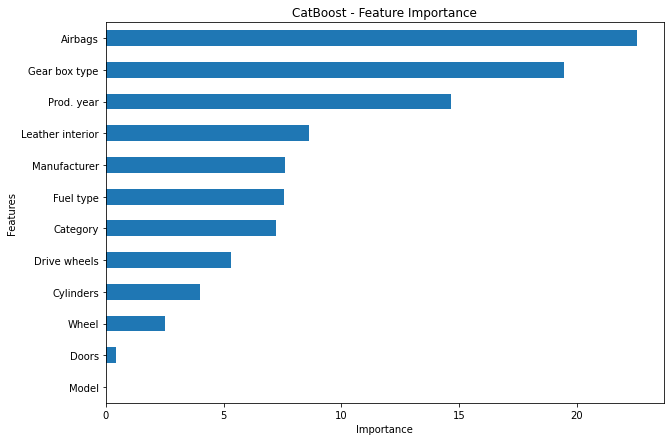

In [184]:
cat_model.feature_importance(cat_model_base_011["model"], ["Manufacturer","Model","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Doors", "Wheel", "Airbags"])

Based on the feature importance, Removing the least 3 features which are least important to solve this problem - Model/Doors/wheels.

In [185]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
          "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":0,\
          'learning_rate': 0.1,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 20, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
          "model_size_reg" : 5,
          "n_estimators": 1000,
          "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
          "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
          "one_hot_max_size": 11, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
          "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_011 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_012)

display(np.exp(cat_model_base_012["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NameError: name 'cat_model_base_012' is not defined

In [186]:
display(cat_model_base_011)

display(np.exp(cat_model_base_011["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

{'mae': 0.6742053196592469,
 'mse': 1.2607457178165768,
 'rmse': 1.1228293360153077,
 'r2': 0.4756451698439086,
 'msle': 0.020003499841019994,
 'rmsle': 0.14143372950261898,
 'model': <catboost.core.CatBoostRegressor at 0x28f20335970>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([9.79722692, 9.51239088, 9.09038687, ..., 9.80653205, 5.18485794,
        9.95738557]),
 'model_score': -7799.939630114222}

array([17983.805169  , 13526.29543621,  8869.61681808, ...,
       18151.92781215,   178.54808361, 21107.53934135])

In [187]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)

features_to_keep = features_to_keep[features_to_keep["Price"] <= 200000]
features_to_keep = features_to_keep[features_to_keep["Price"] >= 1000]

var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
          "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":0,\
          'learning_rate': 0.1,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 20, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
          "model_size_reg" : 5,
          "n_estimators": 1000,
          "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
          "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
          "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
          "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_012 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_012)

display(np.exp(cat_model_base_012["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'mae': 0.677975253654798,
 'mse': 1.2657638246932832,
 'rmse': 1.1250616981718307,
 'r2': 0.4735580966602714,
 'msle': 0.020130291647281768,
 'rmsle': 0.14188125897130235,
 'model': <catboost.core.CatBoostRegressor at 0x28f2034a1f0>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([9.98667828, 9.50242816, 9.02933536, ..., 9.63876323, 5.3215232 ,
        9.94704833]),
 'model_score': -7795.105412519728}

array([21734.98133535, 13392.20584989,  8344.31174702, ...,
       15348.34958406,   204.69543613, 20890.46955594])

#### 20210709

In [6]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", 
                   "Gear box type", \
 "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", \
                           "Gear box type", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
#           "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
#           "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":1000,\
          'learning_rate': 0.8,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 25, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
#           "model_size_reg" : 5,
          ## This parameter influences the model size if training data has categorical features.
          "n_estimators": 200,
#           "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
#           "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
#           "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
#           "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
#           "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
#           "score_function":"L2"  # The score type used to select the next split during the tree construction.
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_012 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_012)

display(np.exp(cat_model_base_012["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.3085210	total: 114ms	remaining: 22.6s
199:	learn: 0.4809276	total: 9m 14s	remaining: 0us


{'mae': 0.7337556615461465,
 'mse': 1.393363538236538,
 'rmse': 1.1804082083061511,
 'r2': 0.4204882942588696,
 'msle': 0.02165961544876645,
 'rmsle': 0.1471720606934837,
 'model': <catboost.core.CatBoostRegressor at 0x2935835d5b0>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.43656058,  9.86223648,  8.59394567, ...,  9.87977208,
         5.02488927, 10.00564645]),
 'model_score': -7967.594661332638}

array([34083.22421313, 19191.76339584,  5398.87390026, ...,
       19531.27058222,   152.15340753, 22151.18902059])

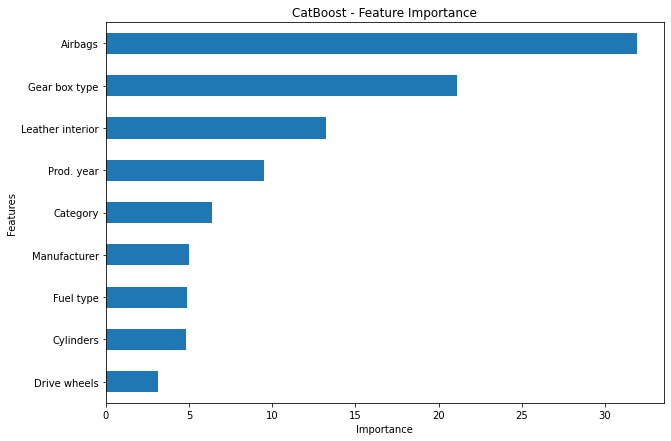

In [12]:
cat_model.feature_importance(cat_model_base_012["model"], ["Manufacturer","Prod. year","Category","Leather interior","Fuel type",
                   "Gear box type", \
"Airbags"])

In [7]:
columns_to_keep = ["Prod. year","Category","Leather interior",
                   "Gear box type", \
 "Airbags", "Price"]

cat_features = ["Prod. year","Category","Leather interior", "Gear box type", \
]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Prod. year","Category","Leather interior", \
                           "Gear box type", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
#           "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
#           "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":1000,\
          'learning_rate': 0.8,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 25, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
#           "model_size_reg" : 5,
          ## This parameter influences the model size if training data has categorical features.
          "n_estimators": 200,
#           "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
#           "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
#           "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
#           "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
#           "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
#           "score_function":"L2"  # The score type used to select the next split during the tree construction.
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_012 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_012)

display(np.exp(cat_model_base_012["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.3289465	total: 27.1ms	remaining: 5.4s
199:	learn: 0.8754942	total: 4m 36s	remaining: 0us


{'mae': 0.8041619571596806,
 'mse': 1.6008768096005592,
 'rmse': 1.2652576060235952,
 'r2': 0.3341817658102463,
 'msle': 0.02445660853948758,
 'rmsle': 0.15638608806248586,
 'model': <catboost.core.CatBoostRegressor at 0x2935e6a7b20>,
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([ 9.66007815,  9.05919498,  8.56353393, ...,  9.71762836,
         6.8046454 , 10.21923187]),
 'model_score': -7734.669799468256}

array([15679.00998511,  8597.22694254,  5237.15622962, ...,
       16607.81025485,   902.02785459, 27425.59193985])

#### GridsearchCV 001

In [8]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", 
                   "Gear box type", \
 "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", \
                           "Gear box type", "Airbags"]

var_dict["dependant"]   = ["Price"]

## make your own scorer for gridsearch
scorer = metrics.make_scorer(metrics.mean_squared_log_error)

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "iterations" : 1000, 
          "verbose":1000,
          
          "grow_policy": "Lossguide",
#           "od_type" : "Iter",
#           "od_wait" : 100
          "random_seed" : 42
         }

other_dict = {}
other_dict["param_grid"] = {'learning_rate': [0.2,0.3, 0.6],
                            'depth': [15,20,25],
                            'l2_leaf_reg': [20,25,30],  ## ideal values are from 10 to 30 
                            
                           }
other_dict["scoring"] = scorer
other_dict["cv"]      = 5  ## general practice to give 5 or 10

# print(features_to_keep.isnull().any())

cat_model = catboost_regressor.new_instance(params)

cat_model_cv_005 = cat_model.model_run_cv_log(features_to_keep, var_dict,  other_dict)

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Manufacturer        False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Gear box type       False
Airbags             False
Price               False
dtype: bool
0:	learn: 1.3521014	total: 149ms	remaining: 2m 28s
999:	learn: 0.9363834	total: 2m 25s	remaining: 0us


In [9]:
display(cat_model_cv_005)

display(np.exp(cat_model_cv_005["y_pred"]))

display(cat_model_cv_005["model"].best_params_)

{'mae': 0.7239923804003241,
 'mse': 1.3273782039029203,
 'rmse': 1.1521190059637592,
 'r2': 0.44793215410177145,
 'grid_search_ad.score': 0.02073494782352556,
 'msle': 0.02073494782352556,
 'rmsle': 0.1439963465631179,
 'model_score': 0.02073494782352556,
 'model': GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x000002935E9D1460>,
              n_jobs=-1,
              param_grid={'depth': [15, 20, 25], 'l2_leaf_reg': [20, 25, 30],
                          'learning_rate': [0.2, 0.3, 0.6]},
              scoring=make_scorer(mean_squared_log_error)),
 'y_test':            Price
 736    10.214092
 8674    9.244742
 5971   10.615702
 1957   10.564576
 11075  10.647874
 ...          ...
 18231  11.788411
 1082   10.493106
 6206    9.303557
 9124    5.398163
 1935    9.345570
 
 [4810 rows x 1 columns],
 'y_pred': array([10.01457068,  9.81113632,  8.41479643, ...,  9.78225359,
         5.24417607,  9.91252523])}

array([22349.75589984, 18235.69688484,  4513.35667448, ...,
       17716.53368827,   189.45965013, 20181.57289314])

{'depth': 15, 'l2_leaf_reg': 20, 'learning_rate': 0.6}

#### 002

Removed the outlier values, price> $ 200000  and price< $ 1000, ideally. The results are promising

In [10]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)

features_to_keep = features_to_keep[features_to_keep["Price"] <= 200000]
features_to_keep = features_to_keep[features_to_keep["Price"] >= 1000]

var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
          "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":0,\
          'learning_rate': 0.1,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 20, 
          "max_depth" : 16,  #max depth /depth of 10 makes sense 
          "model_size_reg" : 5,
          "n_estimators": 1000,
          "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
          "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
          "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
          "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
          "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_012 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_012)

display(np.exp(cat_model_base_012["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'mae': 0.34028448889725577,
 'mse': 0.2738977356321955,
 'rmse': 0.5233524009997427,
 'r2': 0.6634929932097587,
 'msle': 0.0027430405997138346,
 'rmsle': 0.052374045095961747,
 'model': <catboost.core.CatBoostRegressor at 0x293000f3070>,
 'y_test':            Price
 18042   9.727883
 14652  10.167043
 9116    9.554922
 18645  10.202555
 14771  10.227562
 ...          ...
 4434    9.424564
 8126    9.150484
 13010   9.385805
 14412   7.796058
 16237   9.303557
 
 [4163 rows x 1 columns],
 'y_pred': array([9.59440086, 9.86872051, 9.49442158, ..., 9.37253363, 8.56745486,
        9.15901648]),
 'model_score': -7108.872228360432}

array([14682.34243309, 19316.60783676, 13285.40819906, ...,
       11760.875031  ,  5257.7310671 ,  9499.70930224])

In [12]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", \
 "Drive wheels", "Airbags", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels"]


features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = cat_model_base_012["model"].predict(features_to_predict_df)

features_to_predict_df.head()
y_pred = np.exp(y_pred_log)

display(pd.DataFrame({"Price":y_pred}))

,Price
0,18292.883545
1,14596.161796
2,8205.411653
3,4605.100603
4,4188.047651
...,...
8240,6022.320606
8241,14551.481864
8242,43337.149600
8243,42410.398915


In [14]:
prediction_20210710_a = pd.DataFrame({"Price":y_pred})
display(prediction_20210710_a.head())
display(prediction_20210710_a.shape)

,Price
0,18292.883545
1,14596.161796
2,8205.411653
3,4605.100603
4,4188.047651


(8245, 1)

In [15]:
prediction_20210710_a.to_csv("prediction_20210710_a.csv", index = False)

The score is 1.3 and my best without removing outlier is 1.1. The upper bound seems fine, but we might needs to remove the lower bound and the model is overfitting. Need an early stop if overfit. 

#### Trying out some new ideas

1. The filter on price upper and lower boud.
2. 

In [16]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", "Airbags",\
 "Drive wheels", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Airbags", "Cylinders"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)

features_to_keep = features_to_keep[features_to_keep["Price"] <= 200000]
features_to_keep = features_to_keep[features_to_keep["Price"] >= 100]

var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",\
                           "Gear box type", "Drive wheels", "Airbags"]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
#           "od_type":"IncToDec",  # overfitting detector.
          "random_seed" : 42,
#           "colsample_bylevel": 0.5, #  The percentage of features to be used in each split selection. This helps us control overfitting and the values range from (0,1].
          # "iterations" : 100, 
          "verbose":0,\
          'learning_rate': 0.3,
          # "boosting_type" : "Ordered" , # to counter leakage when sample size is small
          ## this one doesnt give good results
          ## This takes time, idk 
          #'depth': 8,   ##depth of the trees
          'l2_leaf_reg': 30, 
          "max_depth" : 15,  #max depth /depth of 10 makes sense 
#           "model_size_reg" : 5,
          "n_estimators": 1000,
          "random_strength": 0.4,  #We use randomness when scoring the splits. Every split gets a score and then we add some randomness to it, this helps to reduce overfitting.
          # "bootstrap_type " :"Bayesian",
#           "bagging_temperature": 2,    # 0 to +infty  / Only with Bayesian bootstraping
          "eval_metric" : "MSLE" , #The metric used for overfitting detection 
           # "grow_policy": "Lossguide" , # The tree growing policy. Defines how to perform greedy tree construction.
#           "min_data_in_leaf" :  10,  # The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.
                              # Can be used only with the Lossguide and Depthwise growing policies.
#           "one_hot_max_size": 4, # Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.
#           "score_function":"L2"
         }


cat_model = catboost_regressor.new_instance(params)

cat_model_base_016 = cat_model.model_run_log(features_to_keep, var_dict )

display(cat_model_base_016)

display(np.exp(cat_model_base_016["y_pred"]))

# 0.1380854363681353 RMSLE Target 0.12 or 0.11
# 1.2031523517963438  MSE

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'mae': 0.5816859127908974,
 'mse': 0.9161538557998119,
 'rmse': 0.957159263550122,
 'r2': 0.554733879398617,
 'msle': 0.011922964820050957,
 'rmsle': 0.10919232949273935,
 'model': <catboost.core.CatBoostRegressor at 0x293582db2b0>,
 'y_test':            Price
 19167   9.842569
 319     8.666130
 17121   9.080459
 9105   10.049275
 2733   10.758817
 ...          ...
 18902   9.214034
 7697    7.581210
 15997   8.692826
 4764   10.333678
 7077    7.540622
 
 [4717 rows x 1 columns],
 'y_pred': array([ 9.28356376,  9.53468432,  6.77668037, ...,  8.7258118 ,
        10.27345202,  7.83787148]),
 'model_score': -7591.9425188349}

array([10759.7086718 , 13831.22943697,   877.15206447, ...,
        6159.87523858, 28953.66359964,  2534.80369465])

In [17]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Cylinders",
                   "Gear box type", "Airbags",\
 "Drive wheels", "Price"]

cat_features = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Gear box type", \
 "Drive wheels", "Airbags", "Cylinders"]


features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = cat_model_base_016["model"].predict(features_to_predict_df)

features_to_predict_df.head()
y_pred = np.exp(y_pred_log)

display(pd.DataFrame({"Price":y_pred}))

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Price
0,15981.371905
1,18385.960977
2,7693.959246
3,4158.817236
4,3025.496143
...,...
8240,6699.854116
8241,18912.204633
8242,6057.812270
8243,19109.523002


In [18]:
prediction_20210710_b = pd.DataFrame({"Price":y_pred})
display(prediction_20210710_b.head())
display(prediction_20210710_b.shape)

,Price
0,15981.371905
1,18385.960977
2,7693.959246
3,4158.817236
4,3025.496143


(8245, 1)

In [19]:
prediction_20210710_b.to_csv("prediction_20210710_b.csv", index = False)

Score - 1.29258, the model still overfit. R2 score is good, and the rsmlse is good as well. 

#### Next Try
1. Cleaned 2 columns with continuous variable, Engine volume and mileage. 

In [22]:
train = pd.read_csv("cleaned_20210710_2339.csv")

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 1.2455947	total: 123ms	remaining: 12.2s
99:	learn: 0.7923072	total: 10.2s	remaining: 0us


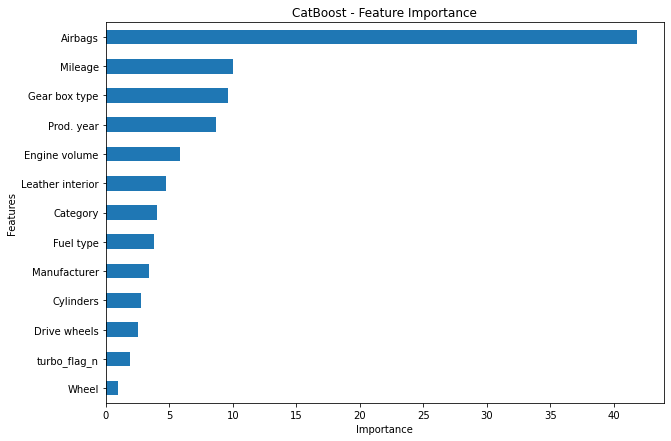

In [24]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Engine volume","Cylinders",
                   "Gear box type", "Mileage","turbo_flag_n", \
 "Drive wheels", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Category","Leather interior","Fuel type", "Gear box type", "turbo_flag_n", 
 "Drive wheels", "Wheel"]

features_to_keep = train[columns_to_keep]

#features_to_keep["Price"] = np.log10(features_to_keep.Price)

features_to_keep[cat_features] = features_to_keep[cat_features].astype(str)


var_dict = {}
var_dict["independant"] = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Engine volume","Cylinders",
                   "Gear box type", "Mileage","turbo_flag_n", \
 "Drive wheels", "Wheel", "Airbags",]

var_dict["dependant"]   = ["Price"]

params = {"cat_features": cat_features, 
          "loss_function": "RMSE", 
          "iterations" : 100, 
          "verbose":100,
         'learning_rate': 0.8,
         'depth': 12,   ##depth of the trees
         'l2_leaf_reg': 30}

cat_model = catboost_regressor.new_instance(params)

cat_model_base_017 = cat_model.model_run_log(features_to_keep, var_dict )

cat_model.feature_importance(cat_model_base_017["model"], var_dict["independant"])

In [28]:
display(cat_model_base_017)

display(np.exp(cat_model_base_017["y_pred"]))

{'mae': 0.6075432743210333,
 'mse': 0.9987348539176673,
 'rmse': 0.9993672267578456,
 'r2': 0.581624262678798,
 'msle': 0.01578527438221224,
 'rmsle': 0.1256394618828505,
 'model': <catboost.core.CatBoostRegressor at 0x2935d99af70>,
 'y_test':            Price
 3434    5.973810
 12927   9.689799
 10936  10.258817
 2480    9.975855
 7699    8.744010
 ...          ...
 6805    7.540622
 17032   6.154858
 11520   9.689799
 6329    7.863651
 16587   9.982299
 
 [4627 rows x 1 columns],
 'y_pred': array([ 7.9534123 , 10.1283753 , 10.36644411, ...,  9.6562613 ,
         8.16109692, 10.01074577]),
 'model_score': -7536.672684487755}

array([ 2845.26729961, 25043.64304356, 31775.28655811, ...,
       15619.27963812,  3502.02592556, 22264.43336042])

In [27]:
test = pd.read_csv("cleaned_20210711_0005_test.csv")

In [29]:
columns_to_keep = ["Manufacturer","Prod. year","Category","Leather interior","Fuel type", "Engine volume","Cylinders",
                   "Gear box type", "Mileage","turbo_flag_n", \
 "Drive wheels", "Wheel", "Airbags", "Price"]

cat_features = ["Manufacturer","Category","Leather interior","Fuel type", "Gear box type", "turbo_flag_n", 
 "Drive wheels", "Wheel"]


features_to_predict_df = test[columns_to_keep]

features_to_predict_df[cat_features] = features_to_predict_df[cat_features].astype(str)


y_pred_log = cat_model_base_017["model"].predict(features_to_predict_df)

features_to_predict_df.head()
y_pred = np.exp(y_pred_log)

display(pd.DataFrame({"Price":y_pred}))

C:\Users\chris.dmello\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Price
0,12954.585460
1,9042.329198
2,6094.226151
3,2137.703550
4,2502.779803
...,...
8240,10149.523655
8241,20404.749743
8242,715.383889
8243,28389.641455


In [30]:
prediction_20210711_b = pd.DataFrame({"Price":y_pred})
display(prediction_20210711_b.head())
display(prediction_20210711_b.shape)

,Price
0,12954.585460
1,9042.329198
2,6094.226151
3,2137.703550
4,2502.779803


(8245, 1)

In [31]:
prediction_20210711_b.to_csv("prediction_20210711_1.csv", index = False)

1. score - 1.00334. 
2. So data cleaning has helped. 
3. Also a simple model is making more sense now. 
4. The submission dataset needs to figured out as well. 

[TODO](https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed)